# Infer ***peroxisome*** - part 7️⃣

--------------
OBJECTIVE:  ✅ Infer sub-cellular component ***peroxisome*** in order to understand interactome 



Dependencies:
The ***peroxisome***  inference rely on the cytoplasm mask.


## preamble

1. imports
2. setup
3. choose_Z
4. get cellmask mask
5. infer nuclei object  
6. get cytoplasm mask


## IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict
from typing import Optional

import numpy as np

from scipy import ndimage as ndi
from aicssegmentation.core.seg_dot import dot_2d_slice_by_slice_wrapper

from skimage.measure import label

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc_2d.core.file_io import (read_czi_image,
                                                                    read_ome_image,
                                                                    export_inferred_organelle,
                                                                    import_inferred_organelle,
                                                                    list_image_files)

from infer_subc_2d.core.img import *

                                                                    
from infer_subc_2d.organelles import fixed_infer_nuclei, get_cytoplasm, get_nuclei, get_cellmask


%load_ext autoreload
%autoreload 2



In [2]:
# NOTE:  these "constants" are only accurate for the testing MCZ dataset
from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROX_CH ,
                                                                    ER_CH ,
                                                                    LD_CH ,
                                                                    RESIDUAL_CH )              


## SETUP

In [3]:
# this will be the example image for testing the pipeline below
test_img_n = TEST_IMG_N

# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
in_data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

# save output ".tiff" files here
out_data_path = data_root_path / "out"

if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [4]:
img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## GET CYTOSOL MASK

> note: don't actually need it here, but getting for testing and visualization purposes.


In [5]:

###################
# SOMA, NUCLEI, CYTOSOL, NUCLEUS
###################
nuclei_obj =  get_nuclei(img_data,meta_dict, out_data_path)
soma_obj = get_cellmask(img_data, nuclei_obj, meta_dict, out_data_path)
cytoplasm_mask = get_cytoplasm(nuclei_obj , soma_obj , meta_dict, out_data_path)



>>>>>>>>>>>> tifffile.imread  (dtype=uint8in (0.01) sec
loaded  inferred 3D `nuclei`  from /Users/ahenrie/Projects/Imaging/data/out 
>>>>>>>>>>>> tifffile.imread  (dtype=int32in (0.02) sec
loaded  inferred 3D `cellmask`  from /Users/ahenrie/Projects/Imaging/data/out 
>>>>>>>>>>>> tifffile.imread  (dtype=uint8in (0.01) sec
loaded  inferred 3D `cytoplasm`  from /Users/ahenrie/Projects/Imaging/data/out 


---------------------

## infer ***peroxisome**

## summary of steps 

INPUT
- ch 4
- cytoplasm mask

PRE-PROCESSING
-  MM scale
-  G2 gaussian filter 2D 
   -  sigma = 1.

CORE-PROCESSING
- S2 - dot filter
- W - watershed to disambiguate overlapping dots

POST-PROCESSING
  - S  - remove dots less than 2x2 pixels (area = 4)

OUTPUT
- object ***peroxisome*** 



Generally following the Allen Cell Segmenter procedure, but doing more aggressive contrast scaling than their prescribed contrast scaling.

> PMP34 os  good start for Peroxisomes  as per from [Allen Cell](https://www.allencell.org/cell-observations/category/peroxisome)

> [playground_dots.ipynb](https://github.com/AllenInstitute/aics-segmentation/blob/master/lookup_table_demo/playground_dots.ipynb)




>#### ASIDE:  3D Spot filter (S3)
>* Parameter syntax: `[[scale_1, cutoff_1], [scale_2, cutoff_2], ....]` 
>    * `scale_x` is set based on the estimated radius of your target dots. For example, if visually the diameter of the dots is usually 3~4 pixels, then you may want to set `scale_x` as `1` or something near `1` (like `1.25`). Multiple scales can be used, if you have dots of very different sizes.  
>    * `cutoff_x` is a threshold applied on the actual filter reponse to get the binary result. Smaller `cutoff_x` may yielf more dots and fatter segmentation, while larger `cutoff_x` could be less permisive and yield less dots and slimmer segmentation. 
>* Parameter for PMP34:  `s3_param = [[1,0.03]]`


## INPUT prototype

In [6]:
###################
# INPUT
###################
raw_peroxi = select_channel_from_raw(img_data, PEROX_CH)


## PRE-PROCESSING prototype

In [7]:
###################
# PRE_PROCESSING
###################
median_sz = 0
gauss_sig = 3.0

struct_img =  scale_and_smooth(raw_peroxi,
                                                    median_sz = median_sz, 
                                                    gauss_sig = gauss_sig)

## CORE PROCESSING prototype

In [8]:
###################
# CORE_PROCESSING
###################

################################
## PARAMETERS for this step ##
dot_2d_sigma = 1
dot_2d_cutoff = 0.01
s2_param = [[dot_2d_sigma,dot_2d_cutoff]]
################################
bw = dot_2d_slice_by_slice_wrapper(struct_img, s2_param)

## POST-PROCESSING prototype

> NOTE:  AllenCell Segmenter suggests using a masked watershed to disambiguate overlapping peroxisome, but it is depricated here as our contrast/separation is pretty good.

In [9]:

###################
# POST_PROCESSING
###################

small_object_width = 2 
peroxi_object = size_filter_linear_size(bw, 
                                                min_size= small_object_width)

#### Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [10]:
viewer = napari.Viewer()


In [11]:


viewer.add_image(
    peroxi_object,
)

viewer.scale_bar.visible = True
viewer.add_image(
    struct_img
)
viewer.add_image(
    bw,
)


<Image layer 'bw' at 0x10c63a430>

## DEFINE `infer_perox` function

Based on the _prototyping_ above define the function to infer the peroxisome.  


In [12]:
##########################
#  infer_perox
##########################
def _infer_perox( in_img: np.ndarray,
                                median_sz: int,
                                gauss_sig: float,
                                dot_scale: float,
                                dot_cut: float,
                                small_obj_w: int,
                            ) -> np.ndarray:
    """
    Procedure to infer peroxisome from linearly unmixed input.

   Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    median_sz: 
        width of median filter for signal
    gauss_sig: 
        sigma for gaussian smoothing of  signal
    dot_scale: 
        scales (log_sigma) for dot filter (1,2, and 3)
    dot_cut: 
        threshold for dot filter thresholds (1,2,and 3)
    small_obj_w: 
        minimu object size cutoff for nuclei post-processing
 
    Returns
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """
    peroxi_ch = PEROX_CH
    ###################
    # EXTRACT
    ###################    
    peroxi = select_channel_from_raw(in_img, peroxi_ch)

    ###################
    # PRE_PROCESSING
    ###################    
    peroxi =  scale_and_smooth(peroxi,
                                                    median_sz = median_sz,            #skips for median_sz < 2
                                                    gauss_sig = gauss_sig)

   ###################
    # CORE_PROCESSING
    ###################
    s3_param = [[dot_scale,dot_cut]]
    bw = dot_2d_slice_by_slice_wrapper(peroxi, s3_param)

    ###################
    # POST_PROCESSING
    ###################
    struct_obj = size_filter_linear_size(bw, 
                                                min_size= small_obj_w, 
                                                connectivity=1)


    return struct_obj

## DEFINE `_fixed_infer_perox` function


In [13]:

##########################
#  fixed_infer_perox
##########################
def _fixed_infer_perox(in_img: np.ndarray) -> np.ndarray:
    """
    Procedure to infer peroxisome from linearly unmixed input with fixed parameters.

   Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
        
    Returns
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """
    median_sz=0
    gauss_sig = 3.
    dot_scale = 1.0
    dot_cut = 0.01
    small_obj_w = 2

    return _infer_perox(in_img,
                                    median_sz,
                                    gauss_sig,
                                    dot_scale,
                                    dot_cut,
                                    small_obj_w,
                                )


# TEST  `_infer_perox` function

In [14]:
_peroxi_object =  _fixed_infer_perox(img_data) 


In [15]:
from infer_subc_2d.organelles import infer_perox, fixed_infer_perox 

peroxi_object =  fixed_infer_perox(img_data) 


## Visualize  2


In [16]:

viewer.add_image(
    peroxi_object)

viewer.add_image(
    _peroxi_object)

viewer.add_labels(
    label(peroxi_object))

<Labels layer 'Labels' at 0x16c46fb80>

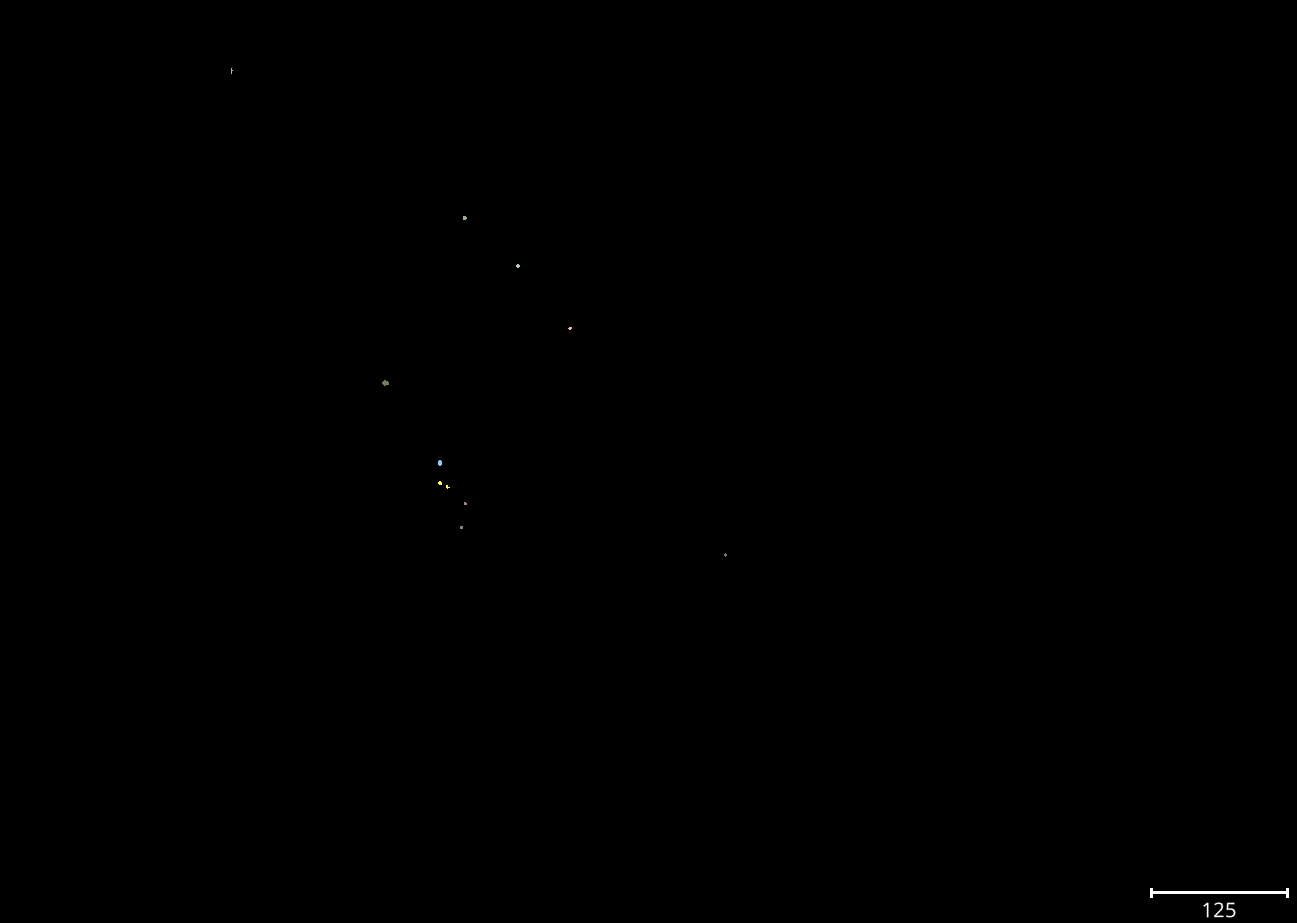

In [17]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)

In [18]:
viewer.close()

-------------
## SUMMARY

The above details how the peroxisome object is inferred.  

### NEXT: INFER ENDOPLASMIC RETICULUM

proceed to [08_infer_ER.ipynb](./08_infer_ER.ipynb)
